# Convolutional neural networks

In this notebook, we'll put together our convolutional layers to implement a 3-layer CNN.  Then, we'll ask you to implement a CNN that can achieve > 65% validation error on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, their layer structure, and their implementation of fast CNN layers.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  


If you have not completed the Spatial BatchNorm Notebook, please see the following description from that notebook:

Please copy and paste your prior implemented code from HW #4 to start this assignment.  If you did not correctly implement the layers in HW #4, you may collaborate with a classmate to use their layer implementations from HW #4.  You may also visit TA or Prof OH to correct your implementation.  

You'll want to copy and paste from HW #4:
    - layers.py for your FC network layers, as well as batchnorm and dropout.
    - layer_utils.py for your combined FC network layers.
    - optim.py for your optimizers.

Be sure to place these in the `nndl/` directory so they're imported correctly.  Note, as announced in class, we will not be releasing our solutions.

In [3]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from nndl.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from nndl.layers import *
from nndl.conv_layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Three layer CNN

In this notebook, you will implement a three layer CNN.  The `ThreeLayerConvNet` class is in `nndl/cnn.py`.  You'll need to modify that code for this section, including the initialization, as well as the calculation of the loss and gradients.  You should be able to use the building blocks you have either earlier coded or that we have provided.  Be sure to use the fast layers.

The architecture of this CNN will be:

conv - relu - 2x2 max pool - affine - relu - affine - softmax

We won't use batchnorm yet.  You've also done enough of these to know how to debug; use the cells below.

Note: As we are implementing several layers CNN networks. The gradient error can be expected for the `eval_numerical_gradient()` function. If your `W1 max relative error` and `W2 max relative error` are around or below 0.01, they should be acceptable. Other errors should be less than 1e-5. 

In [5]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 0.0007994622455933496
W2 max relative error: 0.017868718671677674
W3 max relative error: 0.00023150665501070675
b1 max relative error: 1.5501439730801447e-05
b2 max relative error: 3.9547746586825325e-07
b3 max relative error: 5.304165469623342e-10


### Overfit small dataset

To check your CNN implementation, let's overfit a small dataset.

In [6]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 20) loss: 2.351131
(Epoch 0 / 10) train acc: 0.230000; val_acc: 0.135000
(Iteration 2 / 20) loss: 3.027720
(Epoch 1 / 10) train acc: 0.210000; val_acc: 0.118000
(Iteration 3 / 20) loss: 2.290184
(Iteration 4 / 20) loss: 2.224315
(Epoch 2 / 10) train acc: 0.440000; val_acc: 0.142000
(Iteration 5 / 20) loss: 1.854808
(Iteration 6 / 20) loss: 1.468105
(Epoch 3 / 10) train acc: 0.420000; val_acc: 0.159000
(Iteration 7 / 20) loss: 1.616931
(Iteration 8 / 20) loss: 1.653021
(Epoch 4 / 10) train acc: 0.560000; val_acc: 0.202000
(Iteration 9 / 20) loss: 1.209081
(Iteration 10 / 20) loss: 1.047293
(Epoch 5 / 10) train acc: 0.580000; val_acc: 0.154000
(Iteration 11 / 20) loss: 1.302589
(Iteration 12 / 20) loss: 0.737648
(Epoch 6 / 10) train acc: 0.760000; val_acc: 0.191000
(Iteration 13 / 20) loss: 0.728068
(Iteration 14 / 20) loss: 0.992679
(Epoch 7 / 10) train acc: 0.750000; val_acc: 0.212000
(Iteration 15 / 20) loss: 1.135615
(Iteration 16 / 20) loss: 0.628386
(Epoch 8 / 10) tr

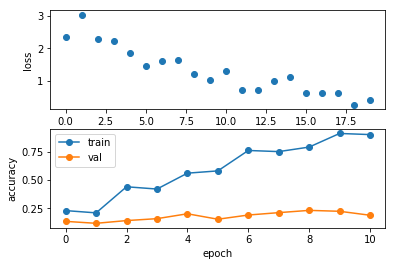

In [7]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the network

Now we train the 3 layer CNN on CIFAR-10 and assess its accuracy.

In [10]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.304778
(Epoch 0 / 1) train acc: 0.096000; val_acc: 0.110000
(Iteration 21 / 980) loss: 2.148870
(Iteration 41 / 980) loss: 1.951109
(Iteration 61 / 980) loss: 2.088101
(Iteration 81 / 980) loss: 2.050137
(Iteration 101 / 980) loss: 2.105432
(Iteration 121 / 980) loss: 1.884327
(Iteration 141 / 980) loss: 1.798437
(Iteration 161 / 980) loss: 1.967353
(Iteration 181 / 980) loss: 1.732003
(Iteration 201 / 980) loss: 1.702158
(Iteration 221 / 980) loss: 1.733384
(Iteration 241 / 980) loss: 1.861732
(Iteration 261 / 980) loss: 2.082490
(Iteration 281 / 980) loss: 1.532739
(Iteration 301 / 980) loss: 1.562658
(Iteration 321 / 980) loss: 1.852730
(Iteration 341 / 980) loss: 1.826933
(Iteration 361 / 980) loss: 1.926121
(Iteration 381 / 980) loss: 1.839934
(Iteration 401 / 980) loss: 1.552935
(Iteration 421 / 980) loss: 1.536522
(Iteration 441 / 980) loss: 1.899579
(Iteration 461 / 980) loss: 1.694684
(Iteration 481 / 980) loss: 1.951358
(Iteration 501 / 980) loss: 

# Get > 65% validation accuracy on CIFAR-10.

In the last part of the assignment, we'll now ask you to train a CNN to get better than 65% validation accuracy on CIFAR-10.

### Things you should try:
- Filter size: Above we used 7x7; but VGGNet and onwards showed stacks of 3x3 filters are good.  
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Batch normalization: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- Network architecture: Can a deeper CNN do better?  Consider these architectures:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple of important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

In [9]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a CNN to achieve greater than 65% validation accuracy
#   on CIFAR-10.
# ================================================================ #

model = ThreeLayerConvNet(num_filters=64, filter_size=3, 
                          weight_scale=0.001, hidden_dim=500, 
                          reg=0.001, use_batchnorm=True)

solver = Solver(model, data,
                num_epochs=10, batch_size=256,
                update_rule='adam',
                optim_config={
                  'learning_rate': 9e-4,
                }, 
#                lr_decay = 0.95,
                verbose=True, print_every=20)
solver.train()
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


(Iteration 1 / 1910) loss: 2.306702
(Epoch 0 / 10) train acc: 0.140000; val_acc: 0.141000
(Iteration 21 / 1910) loss: 1.972687
(Iteration 41 / 1910) loss: 1.704917
(Iteration 61 / 1910) loss: 1.691338
(Iteration 81 / 1910) loss: 1.591819
(Iteration 101 / 1910) loss: 1.645012
(Iteration 121 / 1910) loss: 1.617636
(Iteration 141 / 1910) loss: 1.485266
(Iteration 161 / 1910) loss: 1.558876
(Iteration 181 / 1910) loss: 1.452939
(Epoch 1 / 10) train acc: 0.553000; val_acc: 0.535000
(Iteration 201 / 1910) loss: 1.472746
(Iteration 221 / 1910) loss: 1.402624
(Iteration 241 / 1910) loss: 1.534692
(Iteration 261 / 1910) loss: 1.435865
(Iteration 281 / 1910) loss: 1.448791
(Iteration 301 / 1910) loss: 1.317168
(Iteration 321 / 1910) loss: 1.533656
(Iteration 341 / 1910) loss: 1.364918
(Iteration 361 / 1910) loss: 1.331399
(Iteration 381 / 1910) loss: 1.304814
(Epoch 2 / 10) train acc: 0.646000; val_acc: 0.600000
(Iteration 401 / 1910) loss: 1.351773
(Iteration 421 / 1910) loss: 1.395832
(Iterati

In [ ]:
import numpy as np

from nndl.layers import *
from nndl.conv_layers import *
from cs231n.fast_layers import *
from nndl.layer_utils import *
from nndl.conv_layer_utils import *

import pdb

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

class ThreeLayerConvNet(object):
  """
  A three-layer convolutional network with the following architecture:
  
  conv - relu - 2x2 max pool - affine - relu - affine - softmax
  
  The network operates on minibatches of data that have shape (N, C, H, W)
  consisting of N images, each with height H and width W and with C input
  channels.
  """
  
  def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
               hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
               dtype=np.float32, use_batchnorm=False):
    """
    Initialize a new network.
    
    Inputs:
    - input_dim: Tuple (C, H, W) giving size of input data
    - num_filters: Number of filters to use in the convolutional layer
    - filter_size: Size of filters to use in the convolutional layer
    - hidden_dim: Number of units to use in the fully-connected hidden layer
    - num_classes: Number of scores to produce from the final affine layer.
    - weight_scale: Scalar giving standard deviation for random initialization
      of weights.
    - reg: Scalar giving L2 regularization strength
    - dtype: numpy datatype to use for computation.
    """
    self.use_batchnorm = use_batchnorm
    self.params = {}
    self.reg = reg
    self.dtype = dtype

    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize the weights and biases of a three layer CNN. To initialize:
    #     - the biases should be initialized to zeros.
    #     - the weights should be initialized to a matrix with entries
    #         drawn from a Gaussian distribution with zero mean and 
    #         standard deviation given by weight_scale.
    # ================================================================ #
    #h1outx=((input_dim.shape(0)-filter_size)/2)+1
    #h1outy=((input_dim.shape(1)-filter_size)/2)+1
    self.params['W1']=weight_scale*np.random.randn(num_filters,input_dim[0],filter_size,filter_size)
    self.params['b1']=np.zeros(num_filters)
    self.params['W2']=weight_scale*np.random.randn(int(num_filters*input_dim[1]*input_dim[2]/4),hidden_dim)
    self.params['b2']=np.zeros(hidden_dim)
    self.params['W3']=weight_scale*np.random.randn(hidden_dim,num_classes)
    self.params['b3']=np.zeros(num_classes)


    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    for k, v in self.params.items():
      self.params[k] = v.astype(dtype)
     
 
  def loss(self, X, y=None):
    """
    Evaluate loss and gradient for the three-layer convolutional network.
    
    Input / output: Same API as TwoLayerNet in fc_net.py.
    """
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    W3, b3 = self.params['W3'], self.params['b3']
    
    # pass conv_param to the forward pass for the convolutional layer
    filter_size = W1.shape[2]
    conv_param = {'stride': 1, 'pad': (filter_size - 1) / 2}

    # pass pool_param to the forward pass for the max-pooling layer
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

    scores = None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the three layer CNN.  Store the output
    #   scores as the variable "scores".
    # ================================================================ #
    out,cache1=conv_relu_pool_forward(X,W1,b1,conv_param,pool_param)
    out,cache2=affine_relu_forward(out,W2,b2)
    out,cache3=affine_forward(out,W3,b3)
    scores=out
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    if y is None:
      return scores
    
    loss, grads = 0, {}
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backward pass of the three layer CNN.  Store the grads
    #   in the grads dictionary, exactly as before (i.e., the gradient of 
    #   self.params[k] will be grads[k]).  Store the loss as "loss", and
    #   don't forget to add regularization on ALL weight matrices.
    # ================================================================ #
    loss,grad=softmax_loss(scores,y)
    loss+=0.5*self.reg*(np.sum(self.params['W1']**2)+np.sum(self.params['W2']**2)+np.sum(self.params['W3']**2))
    grad2,dw3,db3=affine_backward(grad,cache3)
    grad3,dw2,db2=affine_relu_backward(grad2,cache2)
    grad3,dw1,db1=conv_relu_pool_backward(grad3,cache1)
    grads['W3']=dw3
    grads['W2']=dw2
    grads['W1']=dw1
    grads['b3']=db3
    grads['b2']=db2
    grads['b1']=db1
    
    

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grads
  
  
pass
def conv_relu_pool_forward(x, w, b, conv_param, pool_param):
  """
  Convenience layer that performs a convolution, a ReLU, and a pool.

  Inputs:
  - x: Input to the convolutional layer
  - w, b, conv_param: Weights and parameters for the convolutional layer
  - pool_param: Parameters for the pooling layer

  Returns a tuple of:
  - out: Output from the pooling layer
  - cache: Object to give to the backward pass
  """
  a, conv_cache = conv_forward_fast(x, w, b, conv_param)
  s, relu_cache = relu_forward(a)
  out, pool_cache = max_pool_forward_fast(s, pool_param)
  cache = (conv_cache, relu_cache, pool_cache)
  return out, cache


def conv_relu_pool_backward(dout, cache):
  """
  Backward pass for the conv-relu-pool convenience layer
  """
  conv_cache, relu_cache, pool_cache = cache
  ds = max_pool_backward_fast(dout, pool_cache)
  da = relu_backward(ds, relu_cache)
  dx, dw, db = conv_backward_fast(da, conv_cache)
  return dx, dw, db
def affine_relu_forward(x, w, b):
  """
  Convenience layer that performs an affine transform followed by a ReLU

  Inputs:
  - x: Input to the affine layer
  - w, b: Weights for the affine layer

  Returns a tuple of:
  - out: Output from the ReLU
  - cache: Object to give to the backward pass
  """
  a, fc_cache = affine_forward(x, w, b)
  out, relu_cache = relu_forward(a)
  cache = (fc_cache, relu_cache)
  return out, cache


def affine_relu_backward(dout, cache):
  """
  Backward pass for the affine-relu convenience layer
  """
  fc_cache, relu_cache = cache
  da = relu_backward(dout, relu_cache)
  dx, dw, db = affine_backward(da, fc_cache)
  return dx, dw, db
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the output of the forward pass.  Notice the dimensions
    #   of w are D x M, which is the transpose of what we did in earlier 
    #   assignments.
    # ================================================================ #
    
    out=np.dot(x.reshape(x.shape[0], -1),w)+b

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
      
    cache = (x, w, b)
    return out, cache
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
      - w: A numpy array of weights, of shape (D, M)
      - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the gradients for the backward pass.
    # Notice:  
    #   dout is N x M
    #   dx should be N x d1 x ... x dk; it relates to dout through multiplication with w, which is D x M
    #   dw should be D x M; it relates to dout through multiplication with x, which is N x D after reshaping
    #   db should be M; it is just the sum over dout examples
    # ================================================================ #

    dx=np.dot(dout,w.T).reshape(x.shape)
    dw=np.dot(x.reshape(x.shape[0], -1).T,dout)
    db=np.sum(dout,axis=0)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dw, db
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx


In [ ]:
import numpy as np
import pdb

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
    
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the output of the forward pass.  Notice the dimensions
    #   of w are D x M, which is the transpose of what we did in earlier 
    #   assignments.
    # ================================================================ #
    
    out=np.dot(x.reshape(x.shape[0], -1),w)+b

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
      
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
      - w: A numpy array of weights, of shape (D, M)
      - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the gradients for the backward pass.
    # Notice:  
    #   dout is N x M
    #   dx should be N x d1 x ... x dk; it relates to dout through multiplication with w, which is D x M
    #   dw should be D x M; it relates to dout through multiplication with x, which is N x D after reshaping
    #   db should be M; it is just the sum over dout examples
    # ================================================================ #

    dx=np.dot(dout,w.T).reshape(x.shape)
    dw=np.dot(x.reshape(x.shape[0], -1).T,dout)
    db=np.sum(dout,axis=0)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dw, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU forward pass.
    # ================================================================ #
    out=x*(x>0)
    cache = x
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    x = cache

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the ReLU backward pass
    # ================================================================ #
    dx=np.ones(x.shape)*(x>0)
    dx=dx*dout
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.
    
    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean
    and variance of each feature, and these averages are used to normalize data
    at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7 implementation
    of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   A few steps here:
        #     (1) Calculate the running mean and variance of the minibatch.
        #     (2) Normalize the activations with the running mean and variance.
        #     (3) Scale and shift the normalized activations.  Store this
        #         as the variable 'out'
        #     (4) Store any variables you may need for the backward pass in
        #         the 'cache' variable.
        # ================================================================ #
        temp_x=x
        sample_mean=np.mean(x,axis=0)
        sample_var=np.var(x,axis=0)
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        a=(x-sample_mean)
        e=sample_var+eps
        c=np.sqrt(e)
        b=1/c
        x_hat=a*b
        x=(x-sample_mean)/np.sqrt(sample_var+eps)
        x=x*gamma+beta
        out=x
        cache=a,e,c,b,x_hat,gamma,sample_var,sample_mean,eps,temp_x
        pass

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the testing time normalized activation.  Normalize using
        #   the running mean and variance, and then scale and shift appropriately.
        #   Store the output as 'out'.
        # ================================================================ #
        x=(x-running_mean)/np.sqrt(running_var+eps)
        x=x*gamma+beta
        out=x
        pass
        
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.
    
    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.
    
    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
    # ================================================================ #
    a,e,c,b,x_hat,gamma,sample_var,sample_mean,eps,x=cache
    dbeta=dout.sum(axis=0)
    dgamma=(dout*x_hat).sum(axis=0)
    dx_hat=dout*gamma
    da=(1/np.sqrt(sample_var+eps))*dx_hat
    db=(x-sample_mean)*dx_hat
    dc=(-1/(sample_var+eps))*db
    de=0.5*((1/np.sqrt(sample_var+eps)))*dc
    dvar=de.sum(axis=0)
    dmu=-da.sum(axis=0)-dvar*(2/x.shape[0])*((x-sample_mean).sum(axis=0))
    dx=(1/np.sqrt(sample_var+eps))*dx_hat+(2*(x-sample_mean)/x.shape[0])*dvar+dmu/x.shape[0]
    
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return dx, dgamma, dbeta

def dropout_forward(x, dropout_param):
    """
    Performs the forward pass for (inverted) dropout.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not in
        real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param['p'], dropout_param['mode']
    if 'seed' in dropout_param:
        np.random.seed(dropout_param['seed'])

    mask = None
    out = None

    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during training time.  
        #   Store the masked and scaled activations in out, and store the 
        #   dropout mask as the variable mask.
        # ================================================================ #
        mask=(np.random.rand(*x.shape)<p)/p
        x=mask*x
        out=x
        
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    
    elif mode == 'test':
        
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout forward pass during test time.
        # ================================================================ #
        
        out=x
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

def dropout_backward(dout, cache):
    """
    Perform the backward pass for (inverted) dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param['mode']
    
    dx = None
    if mode == 'train':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during training time.
        # ================================================================ #
        dx=mask*dout
        
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    elif mode == 'test':
        # ================================================================ #
        # YOUR CODE HERE:
        #   Implement the inverted dropout backward pass during test time.
        # ================================================================ #
        
        dx=dout
        pass
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #
    return dx

def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    N = x.shape[0]
    correct_class_scores = x[np.arange(N), y]
    margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
    margins[np.arange(N), y] = 0
    loss = np.sum(margins) / N
    num_pos = np.sum(margins > 0, axis=1)
    dx = np.zeros_like(x)
    dx[margins > 0] = 1
    dx[np.arange(N), y] -= num_pos
    dx /= N
    return loss, dx


def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx



In [ ]:
from .layers import *

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

def affine_relu_forward(x, w, b):
  """
  Convenience layer that performs an affine transform followed by a ReLU

  Inputs:
  - x: Input to the affine layer
  - w, b: Weights for the affine layer

  Returns a tuple of:
  - out: Output from the ReLU
  - cache: Object to give to the backward pass
  """
  a, fc_cache = affine_forward(x, w, b)
  out, relu_cache = relu_forward(a)
  cache = (fc_cache, relu_cache)
  return out, cache


def affine_relu_backward(dout, cache):
  """
  Backward pass for the affine-relu convenience layer
  """
  fc_cache, relu_cache = cache
  da = relu_backward(dout, relu_cache)
  dx, dw, db = affine_backward(da, fc_cache)
  return dx, dw, db

In [ ]:
import numpy as np

""" 
This code was originally written for CS 231n at Stanford University
(cs231n.stanford.edu).  It has been modified in various areas for use in the
ECE 239AS class at UCLA.  This includes the descriptions of what code to
implement as well as some slight potential changes in variable names to be
consistent with class nomenclature.  We thank Justin Johnson & Serena Yeung for
permission to use this code.  To see the original version, please visit
cs231n.stanford.edu.  
"""

"""
This file implements various first-order update rules that are commonly used for
training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:

def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning rate,
    momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

NOTE: For most update rules, the default learning rate will probably not perform
well; however the default values of the other hyperparameters should work well
for a variety of different problems.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
"""


def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a moving
      average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9) # set momentum to 0.9 if it wasn't there
    v = config.get('velocity', np.zeros_like(w))   # gets velocity, else sets it to zero.
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the momentum update formula.  Return the updated weights
    #   as next_w, and the updated velocity as v.
    # ================================================================ #
    v=np.dot(config['momentum'],v)-np.dot(config['learning_rate'],dw)
    next_w=w+v
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    config['velocity'] = v

    return next_w, config

def sgd_nesterov_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with Nesterov momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a moving
      average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9) # set momentum to 0.9 if it wasn't there
    v = config.get('velocity', np.zeros_like(w))   # gets velocity, else sets it to zero.
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the momentum update formula.  Return the updated weights
    #   as next_w, and the updated velocity as v.
    # ================================================================ #
    temp=v
    v=config['momentum']*temp-config['learning_rate']*dw
    next_w=w+v+config['momentum']*(v-temp)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    config['velocity'] = v

    return next_w, config

def rmsprop(w, dw, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared gradient
    values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - beta: Moving average of second moments of gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('decay_rate', 0.99)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('a', np.zeros_like(w))

    next_w = None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement RMSProp.  Store the next value of w as next_w.  You need
    #   to also store in config['a'] the moving average of the second
    #   moment gradients, so they can be used for future gradients. Concretely,
    #   config['a'] corresponds to "a" in the lecture notes.
    # ================================================================ #
    config['a']=config['decay_rate']*config['a']+(1-config['decay_rate'])*dw*dw
    next_w=w-(config['learning_rate']/(np.sqrt(config['a'])+config['epsilon']))*dw
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return next_w, config


def adam(w, dw, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('a', np.zeros_like(w))
    config.setdefault('t', 0)
    
    next_w = None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement Adam.  Store the next value of w as next_w.  You need
    #   to also store in config['a'] the moving average of the second
    #   moment gradients, and in config['v'] the moving average of the
    #   first moments.  Finally, store in config['t'] the increasing time.
    # ================================================================ #
    t=config['t']
    t+=1
    v=config['v']
    a=config['a']
    beta1=config['beta1']
    beta2=config['beta2']
    eps=config['learning_rate']
    nu=config['epsilon']
    
    
    v=beta1*v+(1-beta1)*dw
    a=beta2*a+(1-beta2)*dw*dw
    v_1=(v/(1-beta1**t))
    a_1=(a/(1-beta2**t))
    
    
    next_w=w-(eps/(np.sqrt(a_1)+nu))*v_1
    config['a']=a
    config['v']=v
    config['t']=t
    
    
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    return next_w, config
